# DATA SCIENCE WINTER TERM PROJECT

-----

## PROJECT: Using Data Science and Machine Learning to Examine and Predict Optimal Shower Time

---------

**GROUP MEMBER:** 
- Trung Nguyen 
- Binh Nguyen


### I. Project Introduction

If you live in Noah, picking a time to shower can be a game of gacha. If you are lucky, the water pressure will be strong and you will have a good time showering. However, if you are unlucky, then you might have a rough time.

This project aim is to find the best time to have a shower using a collection of continuously taken data.

We also look at the trend of the water usage throughout the course of a week, a month, and a year.


In [2]:
import pandas as pd
import numpy as np

### II. Dataset Description

#### A. Dataset Overview
Our dataset is a collective dataset that is continuously taken for the last 5 years, from 2018 to 2021.

The format of the data looks something like this:

|Timestamp    |Water Use (gal)|
|:---         |:----:         |
|1/1/2018 0:00|0              |
|1/1/2018 0:15|0              |
|1/1/2018 0:30|0              |

As the meters take measures every 15 minutes, there will be a period of 15 minutes in between our timestamps.

#### B. Data Cleaning & Preprocessing

We deleted all rows that consist of all null values and incorrectly formatted data. Usually, this is enough. However, as there is a year of 2020 where people cannot be on campus so we decided to get rid of that whole period. We also looked into breaks and shutdowns but as we have those every year so our model will be able to recognize them.

After the cleaning process, we reformatted our data by splitting the our **Timestamp** into different columns: **Month, Day, Time, and Water**

Basically, our new table looks like this:

|     |Month|Day   |Time    |Water  |
|:----|:---:|:-----|:-------|:------|
|**0**|1    |Monday|08:00:00|0.00000|
|**1**|1    |Monday|08:15:00|0.00000|
|**2**|1    |Monday|08:30:00|0.00000|

Our idea is to use **Month, Day, and Time** columns as variables to predict the **Water** column. Now we are ready for some Machine Learning.

In [3]:
df0 = pd.read_csv("Noah_5Years_000.csv", skiprows=4)
df1 = pd.read_csv("Noah_5Years_002.csv", skiprows=4)
df2 = pd.read_csv("Noah_5Years_003.csv", skiprows=4)

df = pd.concat([df0, df1, df2])
df = df[['Timestamp', 'Noah - Water Use (gal)']]
df[['Date', 'Time']] = df['Timestamp'].str.split(' ', expand = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day_name()
df = df[['Date', 'Year', 'Month', 'Day', 'Time', 'Noah - Water Use (gal)']]
df.columns = ['Date', 'Year', 'Month', 'Day', 'Time', 'Water']

df.dropna(inplace=True)

df['Time'] = pd.to_datetime(df['Time']).dt.time

from datetime import time
df = df[df['Time'] >= time(8)]      #Exclude timestamp before 8 am

df = df.reset_index(drop=True)


#Test set: Year 2022
start = df[df['Date'] == '2022-01-01'].iloc[0].name
end = df[df['Date'] == '2022-12-31'].iloc[-1].name
df_test = df.iloc[start: end]
df_train = df.iloc[: start]

df_train = df_train[['Month', 'Day', 'Time', 'Water']]

df_train      #Final dataset

,Month,Day,Time,Water
0,1,Monday,08:00:00,0.00000
1,1,Monday,08:15:00,0.00000
2,1,Monday,08:30:00,0.00000
3,1,Monday,08:45:00,0.00000
4,1,Monday,09:00:00,0.00000
...,...,...,...,...
58063,12,Friday,22:45:00,2.28294
58064,12,Friday,23:00:00,4.01284
58065,12,Friday,23:15:00,7.57591
58066,12,Friday,23:30:00,0.27672


### III. Machine Learning Model

We decided to use Neural Network as our model. As mentioned above, **X** will consist of **Month, Day, and Time** columns and **y** will be the **Water** column.

We splitted our dataset into 2 new sets: the **training set** and the **test set**.

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X = df_train.drop('Water', axis=1)
y = df_train['Water']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
transformer = OneHotEncoder()
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

Our Neural Network consists of 10 neurons and 1 layer. Time to run the model:

In [5]:
rgs = MLPRegressor(hidden_layer_sizes=(10,))
rgs.fit(X_train_transformed, y_train)
y_pred = rgs.predict(X_test_transformed)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Below is our predicted set:

In [6]:
pd.Series(y_pred)

0         7.255170
1        19.593947
2        16.833641
3         8.340524
4         3.365522
           ...    
14512    18.421065
14513    19.987987
14514    11.877639
14515     6.249898
14516     4.198766
Length: 14517, dtype: float64

And below is our test set to compare with our predicted set:

Using r2_score to examine our accuracy:

In [7]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.27767470423780394

In [8]:
df_test = df_test.reset_index(drop=True)
df_test.columns = ['Date', 'Year',	'Month',	'Day',	'Time',	'Water']
df_test

,Date,Year,Month,Day,Time,Water
0,2022-01-01,2022,1,Saturday,08:00:00,1.59134
1,2022-01-01,2022,1,Saturday,08:15:00,0.24213
2,2022-01-01,2022,1,Saturday,08:30:00,0.65721
3,2022-01-01,2022,1,Saturday,08:45:00,0.17295
4,2022-01-01,2022,1,Saturday,09:00:00,0.20754
...,...,...,...,...,...,...
23316,2022-12-31,2022,12,Saturday,22:30:00,1.34901
23317,2022-12-31,2022,12,Saturday,22:45:00,0.86475
23318,2022-12-31,2022,12,Saturday,23:00:00,3.35533
23319,2022-12-31,2022,12,Saturday,23:15:00,2.83638


In [9]:
b = df_test.groupby('Date').apply(lambda d: d.iloc[d['Water'].argsort()[:10]]['Time']) 
b

Date             
2022-01-01  31       15:45:00
            3        08:45:00
            20       13:00:00
            4        09:00:00
            23       13:45:00
                       ...   
2022-12-31  23314    22:00:00
            23320    23:30:00
            23304    19:30:00
            23309    20:45:00
            23311    21:15:00
Name: Time, Length: 3650, dtype: object

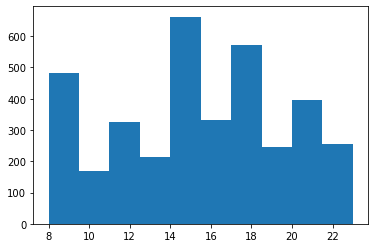

In [10]:
import matplotlib.pyplot as plt
plt.figure()
c = b.apply(lambda x: x.hour)
plt.hist(c)
plt.show()

In [11]:
X_test1 = df_test[['Month', 'Day', 'Time']]
X_test1_tranformed = OneHotEncoder().fit_transform(X_test1)
X_test1['Water'] = rgs.predict(X_test1_tranformed)
X_test1['Date'] = df_test['Date']
a = X_test1.groupby('Date').apply(lambda d: d.iloc[d['Water'].argsort()[:10]]['Time']) 
print(a.head(20))

Date           
2022-01-01  0      08:00:00
            1      08:15:00
            2      08:30:00
            3      08:45:00
            43     18:45:00
            33     16:15:00
            7      09:45:00
            45     19:15:00
            42     18:30:00
            34     16:30:00
2022-01-02  64     08:00:00
            65     08:15:00
            66     08:30:00
            67     08:45:00
            107    18:45:00
            71     09:45:00
            97     16:15:00
            106    18:30:00
            68     09:00:00
            98     16:30:00
Name: Time, dtype: object


C:\Users\admin\AppData\Local\Temp\ipykernel_3168\1073370504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1['Water'] = rgs.predict(X_test1_tranformed)
C:\Users\admin\AppData\Local\Temp\ipykernel_3168\1073370504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1['Date'] = df_test['Date']


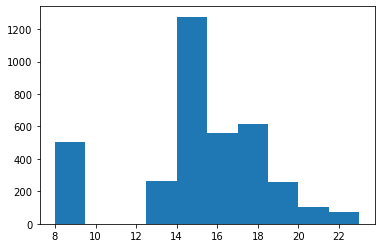

In [12]:
plt.figure()
c = a.apply(lambda x: x.hour)
plt.hist(c)
plt.show()

In [13]:
from datetime import datetime
from datetime import timedelta
def get_3best_time(month=datetime.now().month, day=datetime.now().day, earliest='08:00', latest='23:45', trained_model=rgs):
    earliest = datetime.strptime(earliest, '%H:%M')
    latest = datetime.strptime(latest, '%H:%M')

    time_array = []
    while True:
        time_array.append(earliest.time())
        if earliest == latest:
            break
        earliest += timedelta(minutes=15)
        
    cur_X = pd.DataFrame({'Month': month, 'Day': datetime(datetime.now().year, month, day).strftime('%A'), 'Time': time_array})
    cur_X_transformed = transformer.transform(cur_X)
    y = trained_model.predict(cur_X_transformed)
    cur_X['Water'] = trained_model.predict(cur_X_transformed)
    top_3 = cur_X.iloc[cur_X['Water'].argsort()[:3]]
    return top_3[['Time', 'Water']].reset_index(drop=True)
get_3best_time()    

,Time,Water
0,17:45:00,4.963136
1,15:15:00,5.677910
2,18:30:00,5.954083


In [14]:
month = 1
day = 24
get_3best_time(1, 24, '19:00', '22:00') 

,Time,Water
0,19:45:00,6.561625
1,19:15:00,6.844355
2,19:00:00,7.110597


In [15]:
agg_df = df.groupby(['Day', 'Time']).agg({'Water': 'mean'})

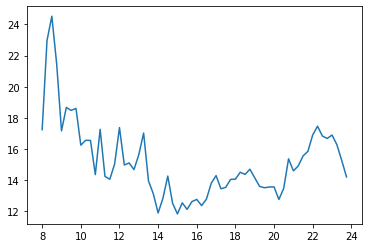

In [30]:
mon = agg_df.loc['Monday']

plt.figure()
plt.plot(np.arange(8, 24, 0.25), mon['Water'])
# plt.ylim(0, 30)
plt.show()

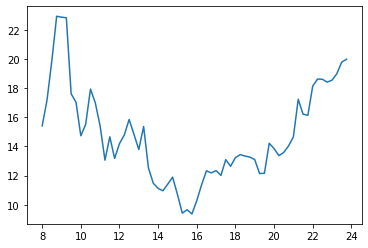

In [31]:
tue = agg_df.loc['Tuesday']

plt.figure()
plt.plot(np.arange(8, 24, 0.25), tue['Water'])
plt.show()

In [18]:
df

,Date,Year,Month,Day,Time,Water
0,2018-01-01,2018,1,Monday,08:00:00,0.00000
1,2018-01-01,2018,1,Monday,08:15:00,0.00000
2,2018-01-01,2018,1,Monday,08:30:00,0.00000
3,2018-01-01,2018,1,Monday,08:45:00,0.00000
4,2018-01-01,2018,1,Monday,09:00:00,0.00000
...,...,...,...,...,...,...
82056,2023-01-11,2023,1,Wednesday,14:30:00,10.03200
82057,2023-01-11,2023,1,Wednesday,14:45:00,12.62555
82058,2023-01-11,2023,1,Wednesday,15:00:00,4.08202
82059,2023-01-11,2023,1,Wednesday,15:15:00,5.05054


In [19]:
new_df = pd.concat([df0, df1, df2])
new_df = new_df[['Timestamp', 'Noah - Water Use (gal)']]
new_df[['Date', 'Time']] = new_df['Timestamp'].str.split(' ', expand = True)
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['Year'] = new_df['Date'].dt.year
new_df['Month'] = new_df['Date'].dt.month
new_df['Day'] = new_df['Date'].dt.day_name()
new_df = new_df[['Date', 'Year', 'Month', 'Day', 'Time', 'Noah - Water Use (gal)']]

new_df.dropna(inplace=True)
new_df

,Date,Year,Month,Day,Time,Noah - Water Use (gal)
0,2018-01-01,2018,1,Monday,00:00,0.00000
1,2018-01-01,2018,1,Monday,00:15,0.00000
2,2018-01-01,2018,1,Monday,00:30,0.00000
3,2018-01-01,2018,1,Monday,00:45,0.00000
4,2018-01-01,2018,1,Monday,01:00,0.00000
...,...,...,...,...,...,...
26092,2023-01-11,2023,1,Wednesday,14:30,10.03200
26093,2023-01-11,2023,1,Wednesday,14:45,12.62555
26094,2023-01-11,2023,1,Wednesday,15:00,4.08202
26095,2023-01-11,2023,1,Wednesday,15:15,5.05054


In [20]:
df2022 = new_df[new_df['Year'] == 2022]
df2022['Noah - Water Use (gal)'].sum(axis = 0)

505818.60224

In [21]:
years = [2018, 2019, 2020, 2021, 2022]
water_use = []

for year in years:
    buffer = new_df[new_df['Year'] == year]
    total = buffer['Noah - Water Use (gal)'].sum(axis = 0)
    water_use.append(total)
    
# water_use
year_record = {
    'Year' : years,
    'Water Use (gal)' : water_use
}

year_df = pd.DataFrame(year_record, columns = ['Year', 'Water Use (gal)'])
year_df

,Year,Water Use (gal)
0,2018,396367.67509
1,2019,192178.86690
2,2020,33499.22911
3,2021,389750.09580
4,2022,505818.60224


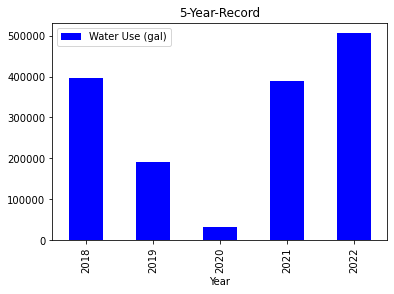

In [22]:
year_df.plot(kind = 'bar', x = 'Year', y = 'Water Use (gal)', color = 'blue')
plt.title('5-Year-Record')
plt.show()

In [23]:
df2022

,Date,Year,Month,Day,Time,Noah - Water Use (gal)
40072,2022-01-01,2022,1,Saturday,00:00,3.63205
40073,2022-01-01,2022,1,Saturday,00:15,5.63877
40074,2022-01-01,2022,1,Saturday,00:30,3.63215
40075,2022-01-01,2022,1,Saturday,00:45,6.19221
40076,2022-01-01,2022,1,Saturday,01:00,0.27672
...,...,...,...,...,...,...
25069,2022-12-31,2022,12,Saturday,22:45,0.86475
25070,2022-12-31,2022,12,Saturday,23:00,3.35533
25071,2022-12-31,2022,12,Saturday,23:15,2.83638
25072,2022-12-31,2022,12,Saturday,23:30,0.89934


In [24]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
monthly_usage_2022 = []

for month in months:
    buffer = df2022[df2022['Month'] == month]
    total = buffer['Noah - Water Use (gal)'].sum(axis = 0)
    monthly_usage_2022.append(total)
    
# monthly_usage
record_of_2022 = {
    'Month' : months,
    'Water Use (gal)' : monthly_usage_2022
}

df_2022_rec = pd.DataFrame(record_of_2022, columns = ['Month', 'Water Use (gal)'])
df_2022_rec

,Month,Water Use (gal)
0,1,44958.98543
1,2,50846.98439
2,3,63220.42987
3,4,50584.17156
4,5,60384.46523
5,6,8917.16964
6,7,2503.42018
7,8,13819.77730
8,9,59754.67702
9,10,54018.68021


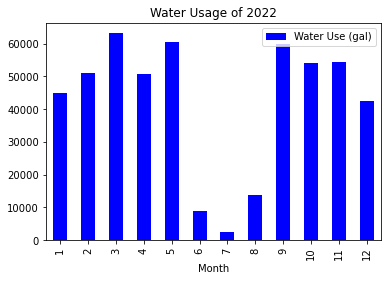

In [25]:
df_2022_rec.plot(kind = 'bar', x = 'Month', y = 'Water Use (gal)', color = 'blue')
plt.title('Water Usage of 2022')
plt.show()

In [26]:
df2021 = new_df[new_df['Year'] == 2021]
monthly_usage_2021 = []

for month in months:
    buffer = df2021[df2021['Month'] == month]
    total = buffer['Noah - Water Use (gal)'].sum(axis = 0)
    monthly_usage_2021.append(total)
    
# monthly_usage
record_of_2021 = {
    'Month' : months,
    'Water Use (gal)' : monthly_usage_2021
}

df_2021_rec = pd.DataFrame(record_of_2021, columns = ['Month', 'Water Use (gal)'])
df_2021_rec

,Month,Water Use (gal)
0,1,17619.68137
1,2,39708.01290
2,3,44386.10663
3,4,43010.03623
4,5,20530.00501
5,6,1694.01337
6,7,2642.14267
7,8,29102.07780
8,9,24505.47861
9,10,61465.04869


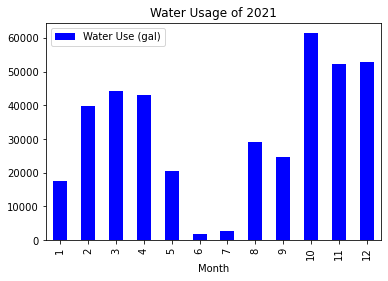

In [27]:
df_2021_rec.plot(kind = 'bar', x = 'Month', y = 'Water Use (gal)', color = 'blue')
plt.title('Water Usage of 2021')
plt.show()